In [19]:
import functools
from pettingzoo import ParallelEnv
from gymnasium import spaces
from typing import Callable, List, Dict, Tuple, Any
import numpy as np
import numpy.typing as npt
from helpers.Paths import BSMPathExtended, MeanRevertingPathFollower, sliding_window_edge_pad

class ParallelTradingEnv(ParallelEnv[int, spaces.Dict, spaces.MultiDiscrete]):   
    def observation_space(self, agent):
        return self.observation_spaces[agent]

    def action_space(self, agent):
        return self.action_spaces[agent]

    def render(self):
        return None
    
    def close(self):
        return None
     
    def _get_stock_midpoint(self):
        stock_midpoint = self.initial_stock_price
        if self.simulation.get_ask_count(self.stock_id) > 0 and self.simulation.get_bid_count(self.stock_id) > 0:
            stock_midpoint = (self.simulation.get_top_ask(self.stock_id).price + self.simulation.get_top_bid(self.stock_id).price) / 2
        return stock_midpoint
    
    def _get_infos(self):
        return {agent_id: {} for agent_id in self.agents}
    
    def _get_terminated(self, is_terminated: bool):
        retval: dict[int, bool] = {}
        for agent_id in self.agents:
            retval[agent_id] = is_terminated
        return retval
    
    def _get_truncated(self):
        retval: dict[int, False] = {}
        for agent_id in self.agents:
            retval[agent_id] = False
        return retval

    def _get_obs(self):
        stock_midpoint = self._get_stock_midpoint()
        stock_bids, stock_asks = self.simulation.get_order_book(self.stock_id)
        
        def book_to_array(orders: list):
            length = self.observation_book_length
            arr = np.zeros((length, 2), dtype=np.float32)
            for i in range(min(length, len(orders))):
                arr[i, 0] = orders[i].price
                arr[i, 1] = orders[i].volume
            return arr

        tick = self.simulation.get_tick()

        order_book_stock_asks  = book_to_array(stock_asks)
        order_book_stock_bids  = book_to_array(stock_bids)
        stock_price_delta      = np.array([(self.stock_midpoints[-1] - self.stock_midpoints[-2]) if len(self.stock_midpoints) >= 2 else 0.0], dtype=np.float32)
        stock_midpoint_price   = np.array([stock_midpoint], dtype=np.float32)
        stock_volatility_5     = np.array([np.std(self.stock_midpoints[-5:])   if len(self.stock_midpoints) >= 5 else 0.0], dtype=np.float32)
        stock_volatility_20    = np.array([np.std(self.stock_midpoints[-20:])  if len(self.stock_midpoints) >= 20 else 0.0], dtype=np.float32)
        stock_volatility_50    = np.array([np.std(self.stock_midpoints[-50:])  if len(self.stock_midpoints) >= 50 else 0.0], dtype=np.float32)
        stock_volatility_100   = np.array([np.std(self.stock_midpoints[-100:]) if len(self.stock_midpoints) >= 100 else 0.0], dtype=np.float32)
        stock_position_limit   = np.array([self.MAX_STOCK_POSITION], dtype=np.float32)
        dividend_current_tick  = np.array([self._get_true_dividend(tick)], dtype=np.float32)
        t                      = np.array([self.simulation.get_t()], dtype=np.float32)

        obs = {}
        for agent_id in self.agents:
            portfolio = self.simulation.get_user_portfolio(agent_id)
            stock_position = np.array([portfolio[self.stock_id]], dtype=np.float32)
            dividend_prediction_1   = np.array([self.agent_dividend_forecast[(agent_id, 1)][tick]], dtype=np.float32)
            dividend_prediction_5   = np.array([self.agent_dividend_forecast[(agent_id, 5)][tick]], dtype=np.float32)
            dividend_prediction_10  = np.array([self.agent_dividend_forecast[(agent_id, 10)][tick]], dtype=np.float32)
            dividend_prediction_20  = np.array([self.agent_dividend_forecast[(agent_id, 20)][tick]], dtype=np.float32)
            dividend_prediction_30  = np.array([self.agent_dividend_forecast[(agent_id, 30)][tick]], dtype=np.float32)
            dividend_prediction_50  = np.array([self.agent_dividend_forecast[(agent_id, 50)][tick]], dtype=np.float32)
            dividend_prediction_100 = np.array([self.agent_dividend_forecast[(agent_id, 100)][tick]], dtype=np.float32)

            obs[agent_id] = {
                "order_book_stock_asks": order_book_stock_asks.copy(),
                "order_book_stock_bids": order_book_stock_bids.copy(),
                "stock_price_delta":     stock_price_delta.copy(),
                "stock_midpoint_price":  stock_midpoint_price.copy(),
                "stock_volatility_5":    stock_volatility_5.copy(),
                "stock_volatility_20":   stock_volatility_20.copy(),
                "stock_volatility_50":   stock_volatility_50.copy(),
                "stock_volatility_100":  stock_volatility_100.copy(),
                "stock_position":        stock_position.copy(),
                "stock_position_limit":  stock_position_limit.copy(),
                "dividend_current_tick": dividend_current_tick.copy(),
                "dividend_prediction_1":   dividend_prediction_1.copy(),
                "dividend_prediction_5":   dividend_prediction_5.copy(),
                "dividend_prediction_10":  dividend_prediction_10.copy(),
                "dividend_prediction_20":  dividend_prediction_20.copy(),
                "dividend_prediction_30":  dividend_prediction_30.copy(),
                "dividend_prediction_50":  dividend_prediction_50.copy(),
                "dividend_prediction_100": dividend_prediction_100.copy(),
                "t": t.copy(),
            }
            pass
        
        for agent_id, agent_obs in obs.items():
            for key, value in agent_obs.items():
                assert isinstance(value, np.ndarray), f"Observation {key} is not a np.ndarray"
                assert value.shape == self.observation_spaces[agent_id][key].shape, f"Shape mismatch for {key}: {value.shape} vs {self.observation_spaces[agent_id][key].shape}"

        return obs
    
    def _initialize_book(self):
        ORDER_COUNT = self.rng.integers(7, 15)
        PRICE_DISTRIBUTION = self.rng.uniform(0.75, 1.0, size=ORDER_COUNT)
        VOLUME_DISTRIBUTION = self.rng.integers(2, 5, ORDER_COUNT)
        SPREAD = 0.02
        WIDENESS = 0.01
        
        stock_bid_top_price = self.initial_stock_price - SPREAD
        stock_bid_bottom_price = stock_bid_top_price - WIDENESS * stock_bid_top_price
        stock_bid_prices = list(
            stock_bid_top_price * PRICE_DISTRIBUTION + stock_bid_bottom_price * (1 - PRICE_DISTRIBUTION)
        )
        
        stock_ask_top_price = self.initial_stock_price + SPREAD
        stock_ask_bottom_price = stock_ask_top_price + WIDENESS * stock_ask_top_price
        stock_ask_prices = list(
            stock_ask_top_price * PRICE_DISTRIBUTION + stock_ask_bottom_price * (1 - PRICE_DISTRIBUTION)
        )
        
        for order_idx in range(ORDER_COUNT):
            self.simulation.direct_insert_limit_order(
                self.anon_id,
                self.stock_id,
                self.Server.OrderSide.BID,
                stock_bid_prices[order_idx],
                VOLUME_DISTRIBUTION[order_idx]
            )
            self.simulation.direct_insert_limit_order(
                self.anon_id,
                self.stock_id,
                self.Server.OrderSide.ASK,
                stock_ask_prices[order_idx],
                VOLUME_DISTRIBUTION[order_idx]
            )
            pass
        pass
    
    def _get_true_dividend(self, tick: int):
        return self.dividend_path[tick]
    
    def get_portfolio(self, agent_id: int):
        return self.simulation.get_user_portfolio(agent_id)
    
    def __init__(self, agent_count: int, render_mode: str|None=None):
        super().__init__()
        self._has_created_simulation = False
        
        self.render_mode = render_mode
        self.metadata = {
            "render_modes": [],
            "name": "ParallelTradingEnv",
            "is_parallelizable": True,
        }
        self.agents = list(range(agent_count))
        self.possible_agents = list(range(agent_count))
        self.observation_book_length = 5
        self.dividend_prediction_horizons = [1, 5, 10, 20, 30, 50, 100]
        self.observation_spaces = {
            agent_id: spaces.Dict({
                "order_book_stock_asks": spaces.Box(low=0.0, high=np.inf, shape=(self.observation_book_length,2), dtype=np.float32), # (price, volume)
                "order_book_stock_bids": spaces.Box(low=0.0, high=np.inf, shape=(self.observation_book_length,2), dtype=np.float32), # (price, volume)
                "stock_price_delta": spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
                "stock_midpoint_price": spaces.Box(low=0.0, high=np.inf, shape=(1,), dtype=np.float32),
                "stock_volatility_5": spaces.Box(low=0.0, high=np.inf, shape=(1,), dtype=np.float32),
                "stock_volatility_20": spaces.Box(low=0.0, high=np.inf, shape=(1,), dtype=np.float32),
                "stock_volatility_50": spaces.Box(low=0.0, high=np.inf, shape=(1,), dtype=np.float32),
                "stock_volatility_100": spaces.Box(low=0.0, high=np.inf, shape=(1,), dtype=np.float32),
                "stock_position": spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
                "stock_position_limit": spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
                "dividend_current_tick": spaces.Box(low=0.0, high=np.inf, shape=(1,), dtype=np.float32),
                "dividend_prediction_1": spaces.Box(low=0.0, high=np.inf, shape=(1,), dtype=np.float32),
                "dividend_prediction_5": spaces.Box(low=0.0, high=np.inf, shape=(1,), dtype=np.float32),
                "dividend_prediction_10": spaces.Box(low=0.0, high=np.inf, shape=(1,), dtype=np.float32),
                "dividend_prediction_20": spaces.Box(low=0.0, high=np.inf, shape=(1,), dtype=np.float32),
                "dividend_prediction_30": spaces.Box(low=0.0, high=np.inf, shape=(1,), dtype=np.float32),
                "dividend_prediction_50": spaces.Box(low=0.0, high=np.inf, shape=(1,), dtype=np.float32),
                "dividend_prediction_100": spaces.Box(low=0.0, high=np.inf, shape=(1,), dtype=np.float32),
                "t": spaces.Box(low=0.0, high=1.0, shape=(1,), dtype=np.float32),
            }) for agent_id in self.agents
        }

        self.RELATIVE_PRICE_BINS = 201
        self.action_spaces = {agent_id: spaces.MultiDiscrete([
            4, # Order type: cancel (all own open limit orders), limit, market, (nothing),
            2, # Side: 0=buy, 1=sell
            self.RELATIVE_PRICE_BINS, # Relative price (gets normalized to [-1$, 1$] inclusive)
            5  # Quantity: (1-5)
        ]) for agent_id in self.agents}
        
        self.rng = np.random.default_rng()
        self.step_count = 1000
        self.dividend_path_smoothing = 21
        pass
    
    def _create_simulation(self):
        if self._has_created_simulation:
            return
        self._has_created_simulation = True
        import python_modules.Server as Server
        self.Server = Server
        
        self.cash = self.Server.GenericSecurities.MarginCash("CASH", 0.0, 0.0)
        self.stock = self.Server.GenericSecurities.DividendStock(
            "STOCK", "CASH", dividend_function=lambda tick: self._get_true_dividend(tick)
        )
        self.simulation = self.Server.GenericSimulation({
            "CASH": self.cash,
            "STOCK": self.stock    
        }, 1.0, self.step_count)
        
        self.cash_id = self.simulation.get_security_id("CASH")
        self.stock_id = self.simulation.get_security_id("STOCK")
        self.initial_stock_price = 100.0
        
        self.MAX_STOCK_POSITION = 30
        
        self.stock_midpoints: List[float] = [self.initial_stock_price]
        
        self.D_0 = 0.1
        self.r = 0.0
        self.sigma = 0.25
        self.T = 1.0
        self.agent_analyst_error_std = 0.0025
        self.forecast_error_std = 0.0005
        
        self.dividend_path = sliding_window_edge_pad(BSMPathExtended(
            self.D_0, self.r, self.sigma, self.T, self.step_count, self.rng, 101
        ), self.dividend_path_smoothing)
        self.agent_dividend_forecast: dict[Tuple[int, int], npt.NDArray[np.float64]] = {}
        self.previous_portfolio_value: dict[int , float] = {}
        for agent_id in self.agents:
            self.simulation.add_user(f"AGENT_{agent_id}")
            agent_analyst_error = self.rng.normal(0, self.agent_analyst_error_std)
            for horizon in self.dividend_prediction_horizons:
                self.agent_dividend_forecast[(agent_id, horizon)] = (
                    self.dividend_path[horizon:self.step_count+horizon+2] +
                    self.rng.normal(agent_analyst_error, self.forecast_error_std, size=(self.step_count + 2))
                )
                pass
            self.previous_portfolio_value[agent_id] = 0.0
            pass
        
        self.anon_id = self.simulation.add_user(f"AGENT_{agent_id}")
        self._initialize_book()
        self.stock_midpoints: List[float] = [self._get_stock_midpoint()]
        for agent_id in self.agents:
            random_stock_amount = self.rng.integers(-self.MAX_STOCK_POSITION, self.MAX_STOCK_POSITION)
            cash_amount = -random_stock_amount * self._get_stock_midpoint()
            self.simulation.do_portfolio_callback(
                lambda x: x.add_to_two_securities(agent_id, self.cash_id, cash_amount, self.stock_id, random_stock_amount)
            )
            pass
        pass
    
    def reset(self, seed=None, options=None):       
        if seed is not None:
            self.rng = np.random.default_rng(seed)
        
        self._create_simulation()
        
        obs = self._get_obs()
        infos = self._get_infos()
        
        self.simulation.reset_simulation()
        self.dividend_path = sliding_window_edge_pad(BSMPathExtended(
            self.D_0, self.r, self.sigma, self.T, self.step_count, self.rng, 101
        ), self.dividend_path_smoothing)
        self.agent_dividend_forecast: dict[Tuple[int, int], npt.NDArray[np.float64]] = {}
        for agent_id in self.agents:
            agent_analyst_error = self.rng.normal(0, self.agent_analyst_error_std)
            for horizon in self.dividend_prediction_horizons:
                self.agent_dividend_forecast[(agent_id, horizon)] = (
                    self.dividend_path[horizon:self.step_count+horizon+2] +
                    self.rng.normal(agent_analyst_error, self.forecast_error_std, size=(self.step_count + 2))
                )
                pass
            self.previous_portfolio_value[agent_id] = 0.0
            pass
        self._initialize_book()
        self.stock_midpoints = [self._get_stock_midpoint()]
        for agent_id in self.agents:
            random_stock_amount = self.rng.integers(-self.MAX_STOCK_POSITION, self.MAX_STOCK_POSITION)
            cash_amount = -random_stock_amount * self._get_stock_midpoint()
            self.simulation.do_portfolio_callback(
                lambda x: x.add_to_two_securities(agent_id, self.cash_id, cash_amount, self.stock_id, random_stock_amount)
            )
            pass
        
        return obs, infos

    def step(self, actions):
        self._create_simulation()
        
        items = list(actions.items())
        self.rng.shuffle(items)
        
        stock_midpoint = self._get_stock_midpoint()
        
        for agent_id, action in items:
            agent_portfolio = self.simulation.get_user_portfolio(agent_id)
            
            action_tuple = tuple(map(lambda x: x, action))
            
            match action_tuple:
                case (0, side, relative_price_idx, quantity): # Cancel all of the agent's limit orders
                    stock_orders = self.simulation.get_all_open_user_orders(agent_id, self.stock_id)
                    for stock_order in stock_orders:
                        self.simulation.submit_cancel_order(agent_id, self.stock_id, stock_order)
                    pass
                case (1, side, relative_price_idx, quantity): # Limit order
                    quantity += 1 # Since the discrete starts at 0
                    # Technically the agent can go beyond the max positions using limit order:
                    # i.e. they submit a bunch but none is executed, then quickly all get executed
                    # resulting in them exceeding the position limit. In this case we only allow
                    # reduce to close their positions.
                    relative_price = -1.0 + (relative_price_idx) / (self.RELATIVE_PRICE_BINS - 1)  # From bin to cents
                    # Stock
                    position = agent_portfolio[self.stock_id]
                    price = round(stock_midpoint + relative_price, 2)
                    if side == 0 and position + quantity <= self.MAX_STOCK_POSITION:
                        # Buy
                        self.simulation.submit_limit_order(agent_id, self.stock_id, self.Server.OrderSide.BID, price, quantity)
                        pass
                    elif side == 1 and position - quantity >= -self.MAX_STOCK_POSITION:
                        # Sell
                        self.simulation.submit_limit_order(agent_id, self.stock_id, self.Server.OrderSide.ASK, price, quantity)
                        pass
                    pass
                case (2, side, relative_price_idx, quantity): # Market order
                    quantity += 1
                    # We allow agents to close positions even if outside limits
                    # Stock
                    position = agent_portfolio[self.stock_id]
                    if side == 0 and position + quantity <= self.MAX_STOCK_POSITION:
                        # Buy
                        self.simulation.submit_market_order(agent_id, self.stock_id, self.Server.OrderAction.BUY, quantity)
                        pass
                    elif side == 1 and position - quantity >= -self.MAX_STOCK_POSITION:
                        # Sell
                        self.simulation.submit_market_order(agent_id, self.stock_id, self.Server.OrderAction.SELL, quantity)
                        pass
                    pass
                case (3, side, relative_price_idx, quantity): # Do nothing
                    pass
                case unmatched:
                    print("Received unmatched case")
                    print(type(unmatched))
                    raise Exception("Received unmatched case.")
            pass
        
        result = self.simulation.do_simulation_step()
        stock_midpoint = self._get_stock_midpoint()
        self.stock_midpoints.append(stock_midpoint)
        
        terminated = not result.has_next_step
        obs = self._get_obs()
        
        trade_count: dict[int, int] = {}
        for transaction in result.transactions["STOCK"]:
            if transaction.buyer_id in trade_count:
                trade_count[transaction.buyer_id] += 1
            else:
                trade_count[transaction.buyer_id] = 1
                
            if transaction.seller_id in trade_count:
                trade_count[transaction.seller_id] += 1
            else:
                trade_count[transaction.seller_id] = 1
            pass
        
        rewards: dict[int, float] = {}
        for agent_id in self.agents:
            portfolio = self.simulation.get_user_portfolio(agent_id)
            cash = portfolio[self.cash_id]
            stock = portfolio[self.stock_id]
            
            trading_reward = trade_count[agent_id] if agent_id in trade_count else -0.01
            
            current_portfolio_value = cash + stock * stock_midpoint
            previous_portfolio_value = self.previous_portfolio_value[agent_id]
            pnl_reward = current_portfolio_value - previous_portfolio_value
            rewards[agent_id] = np.clip(pnl_reward + trading_reward, -10.0, 10.0)
            self.previous_portfolio_value[agent_id] = current_portfolio_value
            pass
        
        infos = self._get_infos()
        terminateds = self._get_terminated(terminated)
        truncateds = self._get_truncated()
        return obs, rewards, terminateds, truncateds, infos
    pass


In [20]:
env = ParallelTradingEnv(agent_count=20)
observations, infos = env.reset()

done = False
while not done:
    actions = { agent: env.action_space(agent).sample() for agent in env.agents }
    observations, rewards, terminated, truncations, infos = env.step(actions)
    done = any(terminated.values())
env.close()

In [21]:
from pettingzoo.test import parallel_api_test
env = ParallelTradingEnv(agent_count=20)
parallel_api_test(env, num_cycles=1000)
env.close()

Passed Parallel API test


In [22]:
import supersuit as ss
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import CheckpointCallback

AGENT_COUNT = 50
TOTAL_TIMESTEPS = 1_500_000

parallel_env = ParallelTradingEnv(agent_count=AGENT_COUNT)
parallel_env = ss.pettingzoo_env_to_vec_env_v1(parallel_env)
parallel_env = ss.concat_vec_envs_v1(
    parallel_env, num_vec_envs=1, num_cpus=1, base_class="stable_baselines3"
)

model = PPO(
    "MultiInputPolicy",
    parallel_env,
    verbose=0,
    tensorboard_log="./v5/ppo_trading_tensorboard/",
    device="cpu",
    policy_kwargs=dict(
        net_arch=dict(pi=[64, 64], vf=[64, 64])
    ),
    learning_rate=1e-4
)

checkpoint_callback = CheckpointCallback(
    save_freq=10_000, save_path="./v5/checkpoints/", name_prefix="ppo_trading"
)

model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=[checkpoint_callback])

model.save("./v5/ppo_trading_final")

[0.001] 0 [18.] [100.]
[0.001] 1 [24.] [100.]
[0.001] 2 [0.] [100.]
[0.001] 3 [22.] [100.]
[0.001] 4 [23.] [100.]
[0.001] 5 [19.] [100.]
[0.001] 6 [6.] [100.]
[0.001] 7 [2.] [100.]
[0.001] 8 [-26.] [100.]
[0.001] 9 [0.] [100.]
[0.001] 10 [4.] [100.]
[0.001] 11 [17.] [100.]
[0.001] 12 [-6.] [100.]
[0.001] 13 [-17.] [100.]
[0.001] 14 [-15.] [100.]
[0.001] 15 [-26.] [100.]
[0.001] 16 [-7.] [100.]
[0.001] 17 [21.] [100.]
[0.001] 18 [-12.] [100.]
[0.001] 19 [3.] [100.]
[0.001] 20 [26.] [100.]
[0.001] 21 [27.] [100.]
[0.001] 22 [11.] [100.]
[0.001] 23 [-17.] [100.]
[0.001] 24 [-21.] [100.]
[0.001] 25 [4.] [100.]
[0.001] 26 [26.] [100.]
[0.001] 27 [-26.] [100.]
[0.001] 28 [7.] [100.]
[0.001] 29 [-30.] [100.]
[0.001] 30 [-25.] [100.]
[0.001] 31 [-22.] [100.]
[0.001] 32 [-3.] [100.]
[0.001] 33 [-3.] [100.]
[0.001] 34 [-23.] [100.]
[0.001] 35 [-9.] [100.]
[0.001] 36 [6.] [100.]
[0.001] 37 [12.] [100.]
[0.001] 38 [-5.] [100.]
[0.001] 39 [26.] [100.]
[0.001] 40 [22.] [100.]
[0.001] 41 [-8.] [100.]

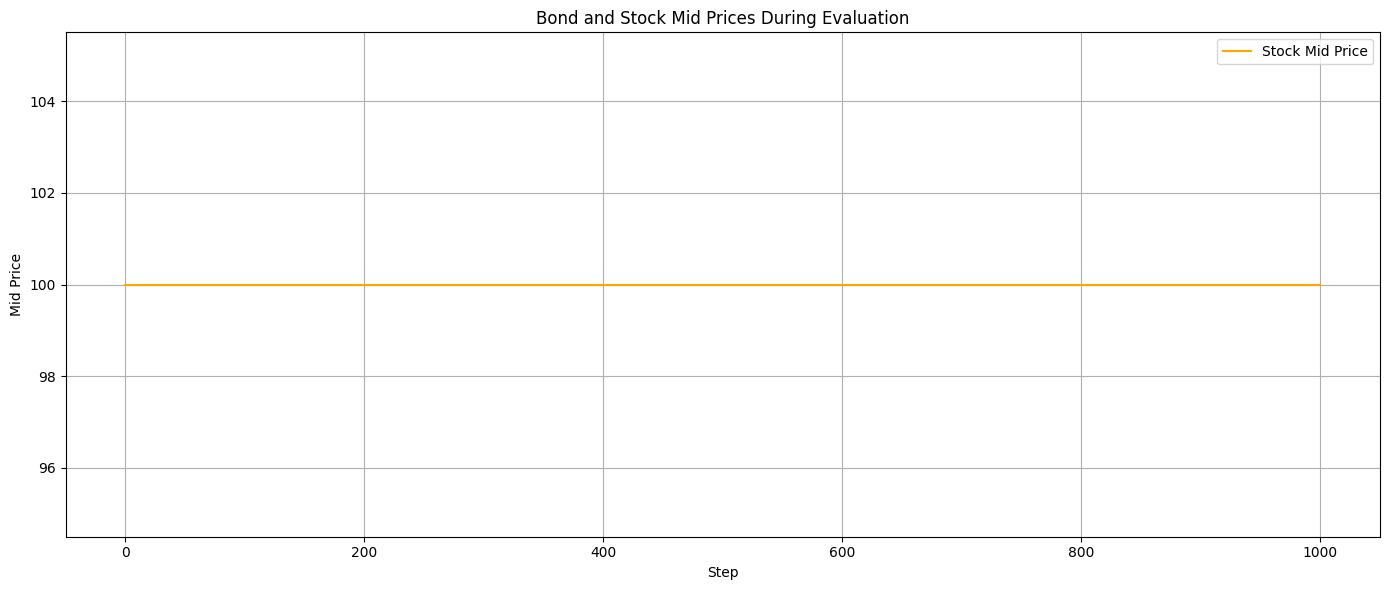

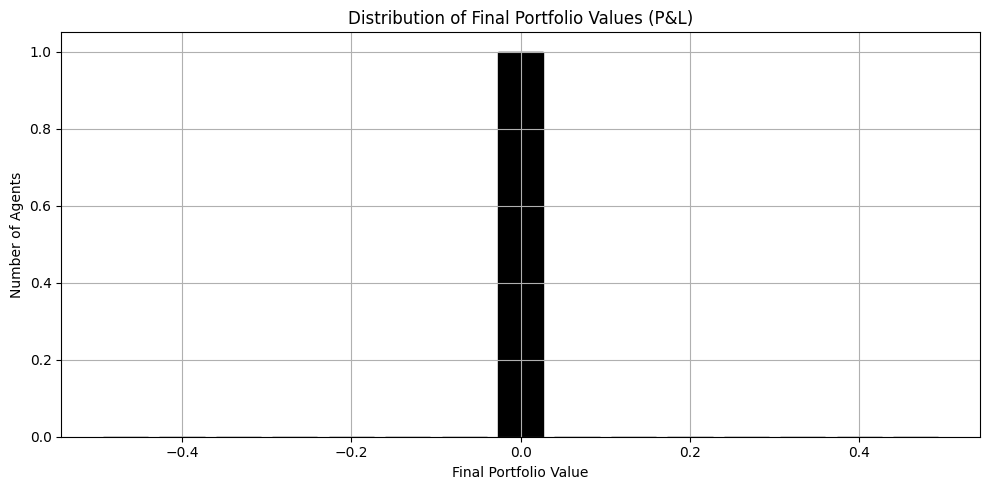

In [24]:
import matplotlib.pyplot as plt

# Paths
MODEL_PATH = "./v5/ppo_trading_final"

# 1. Load environment and wrap it exactly the same way
eval_env = ParallelTradingEnv(agent_count=AGENT_COUNT)
eval_env = ss.pettingzoo_env_to_vec_env_v1(eval_env)
eval_env = ss.concat_vec_envs_v1(
    eval_env, num_vec_envs=1, num_cpus=1, base_class="stable_baselines3"
)

# 2. Load trained model
# model = PPO.load(MODEL_PATH, env=eval_env)

# 3. Reset environment
obs = eval_env.reset()

# 4. Storage for plotting
stock_midpoints = []
portfolio_values = {agent_id: [] for agent_id in range(AGENT_COUNT)}

done = False

# 5. Run one full evaluation episode
while not done:
    # 5a. Predict actions
    action, _states = model.predict(obs, deterministic=True)
        
    # 5b. Step environment
    obs, rewards, dones, infos = eval_env.step(action)

    # 5c. Mid price extraction from observation
    # observations are a list with 1 env -> list of dicts for each agent
    stock_midpoint = obs["stock_midpoint_price"][0]
    stock_midpoints.append(stock_midpoint)

    # 5d. Portfolio tracking (only last known cash/bond/stock positions)
    for agent_id in range(AGENT_COUNT):
        print(obs["t"][agent_id], agent_id, obs["stock_position"][agent_id], obs["stock_midpoint_price"][agent_id])
        
        stock_pos = obs["stock_position"][agent_id]
        portfolio_value = (
            stock_pos * stock_midpoint
        )
        portfolio_values[agent_id].append(portfolio_value)        

    done = dones[0]  # vectorized env with 1 env, so index 0

# 6. Final P&L for each agent
final_pnls = [portfolio_values[agent_id][-1] for agent_id in range(AGENT_COUNT)]

# 7. Plotting results

# 7a. Mid price plots
plt.figure(figsize=(14,6))
plt.plot(stock_midpoints, label="Stock Mid Price", color="orange")
plt.xlabel("Step")
plt.ylabel("Mid Price")
plt.title("Bond and Stock Mid Prices During Evaluation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7b. P&L histogram
plt.figure(figsize=(10,5))
plt.hist(final_pnls, bins=15, edgecolor='black')
plt.xlabel("Final Portfolio Value")
plt.ylabel("Number of Agents")
plt.title("Distribution of Final Portfolio Values (P&L)")
plt.grid(True)
plt.tight_layout()
plt.show()